# Financial Econometrics Project
Author: Joonas Kauto
SCIPER: 349328

In [1]:
# External libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow
from keras import models
from keras import layers
from sklearn.preprocessing import StandardScaler  
import scipy.stats as stats
import math


## Data extraction and preparation

In [9]:
# Let's bring in the data!
df_load = pd.read_csv('stock_prices.csv')

In [10]:
# Let's copy it to different dataframe -  if we have problems we dont need to load the data again from the source.
df = df_load.copy()


In [11]:
# Make the date column to datetime.
df['Date'] = pd.to_datetime(df['Date'])

# Filter out companies who are going to be delisted during the timeperiod:
delisted_companies = df[df['SupervisionFlag'] == True]['SecuritiesCode'].unique()
df = df[~df['SecuritiesCode'].isin(delisted_companies)]

In [12]:
# Filter out columns that are not needed
columns_to_keep = ['RowId',	'Date',	'SecuritiesCode', 'Open', 'High', 'Low', 'Close', 'Volume']
df = df[columns_to_keep]
df

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume
0,20170104_1301,2017-01-04,1301,2734.0,2755.0,2730.0,2742.0,31400
1,20170104_1332,2017-01-04,1332,568.0,576.0,563.0,571.0,2798500
2,20170104_1333,2017-01-04,1333,3150.0,3210.0,3140.0,3210.0,270800
3,20170104_1376,2017-01-04,1376,1510.0,1550.0,1510.0,1550.0,11300
4,20170104_1377,2017-01-04,1377,3270.0,3350.0,3270.0,3330.0,150800
...,...,...,...,...,...,...,...,...
2332526,20211203_9990,2021-12-03,9990,514.0,528.0,513.0,528.0,44200
2332527,20211203_9991,2021-12-03,9991,782.0,794.0,782.0,794.0,35900
2332528,20211203_9993,2021-12-03,9993,1690.0,1690.0,1645.0,1645.0,7200
2332529,20211203_9994,2021-12-03,9994,2388.0,2396.0,2380.0,2389.0,6500


In [13]:
# Number of companies at this point
len_check_1 = len(df.SecuritiesCode.unique())
print("We have", len_check_1, "Different securities!")

We have 1985 Different securities!


In [14]:
# Now lets develop features into our training data
# As you can see, these are derived from past price data only.

def feature_generation(df):

    """
    PS = Has the stock price increased or decreased
    PSY12 = Psychological line for 12 days (DUP12 / 12) * 100
    DU12 = number of dates when price has gone up in 12 days before forecasting date
    
    MA5 = 5 days moving average
    MA10 = 10 days moving average
    MA20 = 20 days moving average
    OS6 = 6 day return
    OS12 = 12 day return
    MTM6 = difference between 6 day closing value
    MTM12 = difference between 12 day closing value
    ASY5 = average stock yield of 5 days before the forecasting day
    ASY4 = average stock yield of 4 days before the forecasting day
    ASY3 = average stock yield of 3 days before the forecasting day
    ASY2 = average stock yield of 2 days before the forecasting day
    ASY1 = average stock yield of 1 days before the forecasting day
    CL3 = Closing price of 3 days before forecasting date
    CL2 = Closing price of 3 days before forecasting date
    CL1 = Closing price of 3 days before forecasting date
    VOL20_price = Closing price's standard deviation from 20 days
    df_i['BOL_UPPER'] = (df_i['Close'] - (df_i['MA20'] + df_i['VOL20_price']*2)) / (df_i['MA20'] + df_i['VOL20_price']*2)
    df_i['BOL_LOWER'] = (df_i['Close'] - (df_i['MA20'] - df_i['VOL20_price']*2)) / (df_i['MA20'] - df_i['VOL20_price']*2)
    """
    # The growth during one trading day
    df['DayReturn'] = (df['Close'] - df['Open'])/df['Open']
    
    def psychological_effect(r):
        if r >= 0:
            return 1
        else:
            return 0
        
    df['PS'] = df.apply(lambda x: psychological_effect(x['DayReturn']),axis=1)

    df_temp = pd.DataFrame()

    check_time = len(df.SecuritiesCode.unique())
    timer = 0
    for security in df.SecuritiesCode.unique():
        
        # Let's look at the data security at time
        df_i = df[df['SecuritiesCode'] == security]
        df_i = df_i.sort_values(by="Date")

        # moving averages
        df_i['MA5'] = df_i['Close'].rolling(5).mean()
        df_i['MA10'] = df_i['Close'].rolling(10).mean()
        df_i['MA20'] = df_i['Close'].rolling(20).mean()

        # Bias

        df_i['BIAS5'] = (df_i['Close'] - df_i['MA5']) / df_i['MA5']


        # The psychology factor
        df_i['PS12'] = df_i['PS'].rolling(12).mean()

        # Closing values, used in calculations
        closing_values = df_i['Close'].values

        # Target variable is the (Close price (t+1) - Close price(t)) / Close price (t)
        target = (closing_values[1:] - closing_values[:-1]) / closing_values[:-1]
        target = np.append(target, np.nan)

        df_i['TargetVariable'] = target

        # Oscillation values AKA differences between prices
        helper = np.array([np.nan,np.nan,np.nan,np.nan,np.nan,np.nan])
        big_helper = np.array([np.nan,np.nan,np.nan,np.nan,np.nan,np.nan, np.nan,np.nan,np.nan,np.nan,np.nan,np.nan])
        OSC6 = closing_values[6:] / closing_values[:-6]
        OSC12 = closing_values[12:] / closing_values[:-12]
        OSC6 = np.append(helper, OSC6)
        OSC12 = np.append(big_helper, OSC12)
        df_i['OSC6'] = OSC6
        df_i['OSC12'] = OSC12


        # Momentum
        MTM6 = closing_values[6:] - closing_values[:-6]
        MTM12 = closing_values[12:] - closing_values[:-12]

        MTM6 = np.append(helper, MTM6)
        MTM12 = np.append(big_helper, MTM12)
        df_i['MTM6'] = MTM6
        df_i['MTM12'] = MTM12

        # Yields
        ASY1 = (closing_values[1:] - closing_values[:-1]) / closing_values[:-1]
        ASY1 = np.insert(ASY1, 0, np.nan)
        df_i['ASY1'] = ASY1
        df_i['ASY5'] = df_i['ASY1'].rolling(5).mean()
        df_i['ASY4'] = df_i['ASY1'].rolling(4).mean()
        df_i['ASY3'] = df_i['ASY1'].rolling(3).mean()
        df_i['ASY2'] = df_i['ASY1'].rolling(2).mean()

        # Volatilities
        df_i['Vol5'] = df_i['ASY1'].rolling(5).std()
        df_i['Vol10'] = df_i['ASY1'].rolling(10).std()
        df_i['Vol20'] = df_i['ASY1'].rolling(20).std()

        # Bollinger bands
        df_i['VOL20_price'] = df_i['Close'].rolling(20).std()

        df_i['BOL_UPPER'] = (df_i['Close'] - (df_i['MA20'] + df_i['VOL20_price']*2)) / (df_i['MA20'] + df_i['VOL20_price']*2)
        df_i['BOL_LOWER'] = (df_i['Close'] - (df_i['MA20'] - df_i['VOL20_price']*2)) / (df_i['MA20'] - df_i['VOL20_price']*2)

        if df_temp.empty:
            df_temp = df_i
        else:
            df_temp = df_temp.append(df_i, ignore_index=True)
    
    return df_temp


In [15]:
df_features = feature_generation(df)


In [16]:
# Number of companies at this point
len_check_2 = len(df_features.SecuritiesCode.unique())
df_filled = df_features.dropna() # Dropnans
len_check_3 = len(df_filled.SecuritiesCode.unique())

# Sanity check
print("This should be zero:", len_check_2- len_check_3)

This should be zero: 0


In [17]:
# Let's decide the date split
N_dates = len(df_filled.Date.unique())
n_after_test = int(np.floor(1161 * 0.7))
dates_ = df_filled.Date.unique()
print("After the day index of", n_after_test, "which is", dates_[int(n_after_test)], " is the test data.")

After the day index of 812 which is 2020-06-03T00:00:00.000000000  is the test data.


In [19]:
# Split the data for the neural network training and testing
df_ = df_filled.copy()
df_ = df_.sort_values(by=['Date'])
df_train = df_.head(n_after_test*len_check_3)
df_test = df_.tail((len(dates_) - n_after_test)*len_check_3)

# Data analysis

In [20]:
# Group data
df_grouped = df_train.groupby(['Date']).mean()

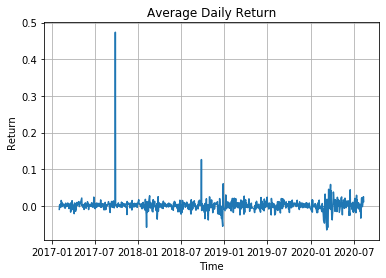

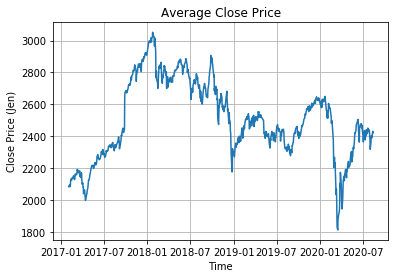

In [21]:
# plot average daily return and average daily close price
fig, ax = plt.subplots()
ax.plot(df_grouped.index, df_grouped['ASY1'])

ax.set(xlabel='Time', ylabel='Return',
       title='Average Daily Return')
ax.grid()
plt.show()

fig, ax = plt.subplots()
ax.plot(df_grouped.index, df_grouped['Close'])

ax.set(xlabel='Time', ylabel='Close Price (Jen)',
       title='Average Close Price')
ax.grid()
plt.show()



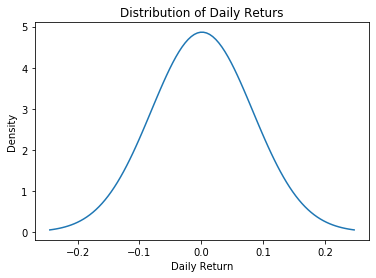

In [22]:

# plot distribution of the daily returns
fig, ax = plt.subplots()
mu = df_train['ASY1'].mean()
sigma =  df_train['ASY1'].std()
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
ax.plot(x, stats.norm.pdf(x, mu, sigma))
ax.set(xlabel='Daily Return', ylabel='Density',
       title='Distribution of Daily Returs')
plt.show()



In [23]:
# From here on grouped by security
df__ = df_train[['Date', 'SecuritiesCode', 'Close', 'ASY1']]
df_security_grouped_std = df__.groupby(['SecuritiesCode']).std()
df_security_grouped_mean = df__.groupby(['SecuritiesCode']).mean()

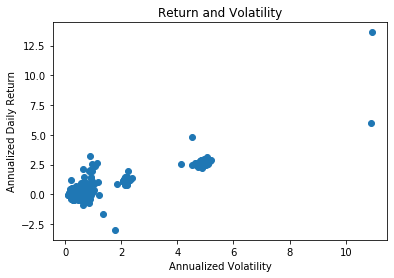

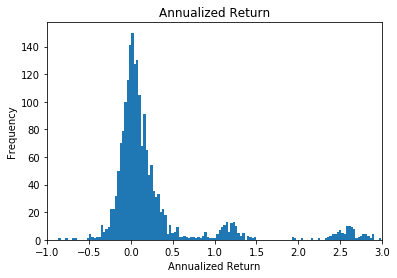

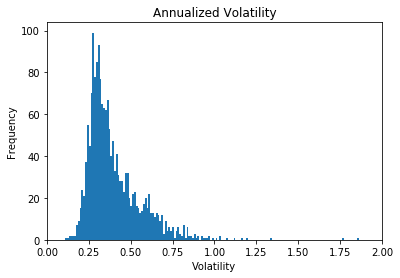

In [25]:
# print out return and volatility
vols = df_security_grouped_std['ASY1']*np.sqrt(252)
means_returns = df_security_grouped_mean['ASY1']*252
fig, ax = plt.subplots()
ax.scatter(vols,  means_returns)
ax.set(xlabel='Annualized Volatility', ylabel='Annualized Daily Return',
       title='Return and Volatility')
plt.show()

fig, ax = plt.subplots()
ax.hist(means_returns, bins=1000)
ax.set(xlabel='Annualized Return', ylabel='Frequency',
       title='Annualized Return')
plt.xlim(-1, 3)
plt.show()

fig, ax = plt.subplots()
ax.hist(vols, bins=1000)
ax.set(xlabel='Volatility', ylabel='Frequency',
       title='Annualized Volatility')
plt.xlim(0, 2)
plt.show()


In [26]:
# check the daily return mean
print("Mean one day return:", df_train['ASY1'].mean())


Mean one day return: 0.001036722283111171


### standardizing our features


In [27]:
# Features to be standardized
feature_columns = [ 'Open', 'High', 'Low', 'Close',
       'Volume', 'DayReturn', 'PS', 'MA5', 'MA10', 'MA20', 'BIAS5',
       'PS12', 'OSC6', 'OSC12', 'MTM6', 'MTM12', 'ASY1',
       'ASY5', 'ASY4', 'ASY3', 'ASY2', 'Vol5', 'Vol10', 'Vol20', 'VOL20_price',
       'BOL_UPPER', 'BOL_LOWER']

# Split the data and filter out useless columns.
test = df_test[feature_columns]
train = df_train[feature_columns]
Y_train = df_train[['TargetVariable']]
Y_test = df_test[['TargetVariable']]

In [28]:
# Lets standardize our parameters.
from sklearn.preprocessing import StandardScaler  
scaler = StandardScaler()  

# Don't cheat - fit only on training data
scaler.fit(train.dropna())  
X_train = scaler.transform(train.dropna())  

# apply same transformation to test data
X_test = scaler.transform(test)  

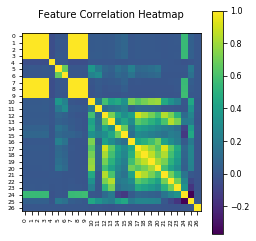

In [29]:

# print out Pearson's correlation heatmap
def show_heatmap(data):
    plt.matshow(data.corr())
    plt.xticks(range(data.shape[1]), data.columns, fontsize=6, rotation=90)
    plt.gca().xaxis.tick_bottom()
    plt.yticks(range(data.shape[1]), data.columns, fontsize=6)

    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=8)
    plt.title("Feature Correlation Heatmap", fontsize=10)
    plt.show()


show_heatmap(pd.DataFrame(X_train))

# The actual model

In [30]:
# A function used for measuring errors
# We use mean average error and mean squared error
def check_error_rates(Y_pred, Y_test):
    mae = tensorflow.keras.losses.MeanAbsoluteError()
    mse = tensorflow.keras.losses.MeanSquaredError()
    mae_result = mae(Y_test, Y_pred).numpy()

    mse_result = mse(Y_test, Y_pred).numpy()
    
    return(mse_result, mae_result)


## Deep neural network

We are using a deep neural network with Tensorflow and keras.
The focal model has been selected from related academic literature and based on some prior testing done by me on the dataset.
The activation functions used are relu and we use 2 hidden layers with diminishing number of nodes. The model seems to converge after 1 epoch and based on the law of diminishing returns we do not see much of predictive performance development after it.

The model runtime is approximately 40 minutes.

In [31]:
model = models.Sequential()
model.add(layers.Dense(27, input_dim=27)) # input layer
model.add(layers.Dense(14, activation='relu')) # first hidden layer
model.add(layers.Dense(7, activation='relu')) # Second hidden layer
model.add(layers.Dense(1)) # output layer

# Compile model
model.compile(optimizer=tensorflow.keras.optimizers.SGD(learning_rate=0.0001), loss='mean_squared_error')

# Fit the mode
history= model.fit(X_train, Y_train, validation_data=(X_test,Y_test), epochs=10, batch_size=19, verbose=True)

Epoch 1/10
84833/84833 [==============================] - 176s 2ms/step - loss: 0.0715 - val_loss: 0.0030
Epoch 2/10
84833/84833 [==============================] - 127s 1ms/step - loss: 0.0130 - val_loss: 0.0015
Epoch 3/10
84833/84833 [==============================] - 142s 2ms/step - loss: 0.0073 - val_loss: 0.0013
Epoch 4/10
84833/84833 [==============================] - 174s 2ms/step - loss: 0.0071 - val_loss: 0.0013
Epoch 5/10
84833/84833 [==============================] - 170s 2ms/step - loss: 0.0070 - val_loss: 0.0012
Epoch 6/10
84833/84833 [==============================] - 183s 2ms/step - loss: 0.0069 - val_loss: 0.0012
Epoch 7/10
84833/84833 [==============================] - 144s 2ms/step - loss: 0.0069 - val_loss: 0.0012
Epoch 8/10
84833/84833 [==============================] - 121s 1ms/step - loss: 0.0069 - val_loss: 0.0012
Epoch 9/10
84833/84833 [==============================] - 124s 1ms/step - loss: 0.0068 - val_loss: 0.0011
Epoch 10/10
84833/84833 [=====================

In [32]:
# Print out the test errors
Y_pred = model.predict(X_test)
mse_main, mae_main = check_error_rates(Y_pred, Y_test)
print("MSE:", mse_main, "MAE:", mae_main)

MSE: 0.001141027 MAE: 0.01750026


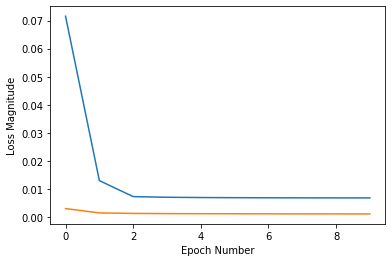

In [33]:
# plot the model's performance per epoch
plt.xlabel('Epoch Number')
plt.ylabel("Loss Magnitude")
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

This company's MSE: 0.0008310513


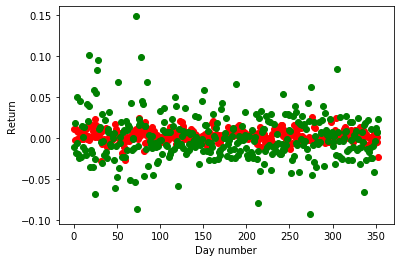

In [34]:
# Let's plot of a randomly selected security's price development for the test period and our prediction of the price development.
sec = df_test.SecuritiesCode.unique()[23] # Select a security
df_plot_X = df_test[df_test['SecuritiesCode'] == sec][feature_columns] # dates used as a x-axis
Y_test_plot = df_test[df_test['SecuritiesCode'] == sec]['TargetVariable'] # select the predicted value
X_plot = scaler.transform(df_plot_X) 
Y_pred_plot = model.predict(X_plot)

# Get the MSE value
mse = tensorflow.keras.losses.MeanSquaredError()

# print out MSE
print("This company's MSE:", mse(Y_test_plot.values, Y_pred_plot).numpy())

# Plot the time period
plt.plot(Y_pred_plot,linestyle="",marker="o", color="r")
plt.plot(Y_test_plot.values,linestyle="",marker="o", color="g")
plt.xlabel('Day number')
plt.ylabel("Return")
plt.show()

## Comparison models